In [1]:
from imports import *

# Scraping


! python scrape_article_urls.py

! python scrape_article_data.py

# Merge daily DF and all time DF

In [2]:
daily_df=pd.read_csv('data/daily_df.csv')

In [3]:
df=pd.read_csv('data/all_time_unprocessed.csv')

In [4]:
df=pd.concat([df,daily_df],ignore_index=True)

In [5]:
df=df.drop_duplicates(subset=['Article ID','Date Published'])

In [6]:
if len(df) > 50 * 10**3:
    df.to_csv('data/all_time_unprocessed.csv', index=False)
else:
    raise ValueError('DataFrame length is not greater than 50,000. Cannot proceed.')

# Processing

In [7]:
#article ID
df['Article ID']=df['Article ID'].str.replace('ID|-','',regex=True).str.strip()

In [8]:
# Date Published and Time Scraped
month_dict={
 'იან':'January',
 'თებ':'February',
 'მარ':'March',
 'აპრ':'April',
 'მაი':'May',
 'ივნ':'June',
 'ივლ':'July',
 'აგვ':'August',
 'სექ':'September',
 'ოქტ':'October',
 'ნოე':'November',
 'დეკ':'December'
}

df['Date Published']=df['Date Published'].replace(month_dict, regex=True)
df['Date Published']=pd.to_datetime(df['Date Published'],errors='coerce').dt.date

#time_scraped=df['Time Scraped'].tolist()
#df=df.drop(columns='Time Scraped')
#df.insert(
#    df.columns.get_loc('Date Published')+1,
#    'Time Scraped',
#    time_scraped
#)

In [9]:
#Addresses
df.drop('General Address',axis=1,errors='ignore',inplace=True)
df.insert(
    df.columns.get_loc('Address'),
    'General Address',
    df['Title'].apply(lambda x:x.split('ბინა ')[-1] if isinstance(x,str) else None)
)
suburb_dict={
    'აეროპორტ': 'აეროპორტის დასახლება',
    'ავჭალ': 'ავაჭალა',
    'ავლაბარ': 'ავლაბარი',
    'აფრიკ': 'აფრიკის დასახლება',
    'ბაგებ': 'ბაგები',
    'გლდან': 'გლდანი',
    'დიდ დიღომ': 'დიდი დიღომი',
    'დიდი დიღომ': 'დიდი დიღომი',
    'დიდუბ': 'დიდუბე',
    'დიღმის მასივ': 'დიღმის მასივი',
    'მასივ': 'დიღმის მასივი',
    'დიღომი 1': 'დიღომი',
    'ვაზისუბ': 'ვაზისუბანი',
    'ვაკე': 'ვაკე',
    'ვაჟა': 'ვაჟა-ფშაველა',
    'ფშაველა': 'ვაჟა-ფშაველა',
    'ვარკეთილ': 'ვარკეთილი',
    'ვაშლიჯ': 'ვაშლიჯვარი',
    'ვერა': 'ვერა',
    'ვეძის': 'ვეძისი',
    'ზაჰეს': 'ზაჰესი',
    'თემქ': 'თემქა',
    'ივერთუბ': 'ივერთუბანი',
    'ისან': 'ისანი',
    'ლილო': 'ლილოს დასახლება',
    'ლისის': 'ლისის ტბის დასახლება',
    'ლისზე': 'ლისის ტბის დასახლება',
    'მთაწმინდ': 'მთაწმინდა',
    'მუხიან': 'მუხიანი',
    'ნავთლუღ': 'ნავთლუღი',
    'ნაძალად': 'ნაძალადევი',
    'ნახალოვ': 'ნახალოვკა',
    'ნუცუბიძ': 'ნუცუბიძის პლატო',
    'ორთაჭალ': 'ორთაჭალა',
    'ორხევ': 'ორხევი',
    'საბურთალ': 'საბურთალო',
    'სამგორ': 'სამგორი',
    'სანზონ': 'სანზონა',
    'სოლოლაკ': 'სოლოლაკი',
    'სოფელ დიღომ': 'სოფელი დიღომი',
    'სოფელი დიღომ': 'სოფელი დიღომი',
    'სოფ. დიღო': 'სოფელი დიღომი',
    'ფონიჭ': 'ფონიჭალა',
    'ჩუღურეთ': 'ჩუღურეთი',
    'ძველ თბილი': 'ძველი თბილისი',
    'ძველი თბილი': 'ძველი თბილისი'
 }

def contains_key(x):
    for key, value in suburb_dict.items():
        if key in str(x):
            return value
    return None


#make more general
df['General Address'] = df['General Address'].apply(contains_key)

df.drop('Detailed Address',axis=1,errors='ignore',inplace=True)
df.insert(
    df.columns.get_loc('Address'),
    'Detailed Address',
    df['Address'].apply(lambda x:x.split(', ')[-1] if isinstance(x,str) else None)
)

In [10]:
df['address_simplified']=df['Address'].apply(lambda x:
                    'თბილისი,'+x.split('ქ.')[0].split('გამზ')[0].replace(' 0','').replace(' 1','').replace(' 2','').replace(' 3','').split(',')[-1] if isinstance(x,str) else None
                    )


coordinates_dict=pickle.load(open("data/coordinates_dict.pickle",'rb'))

def map_coordinates(address):
    if address in coordinates_dict:
        return coordinates_dict[address]
    else:
        return {'Lat': None, 'Lon': None, 'Street': None}
    
mapped_coordinates=df['address_simplified'].apply(map_coordinates)
mapped_df=pd.DataFrame(mapped_coordinates.tolist(),index=df.index)
df=pd.concat([df,mapped_df],axis=1)

df=df.drop(columns='address_simplified')

In [11]:
def ast_(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

df['Details_1']=df['Details_1'].apply(lambda x:ast_(x))
df['Details_2']=df['Details_2'].apply(lambda x:ast_(x))


df['Area SQMT'] = [str(i['საერთო ფართი']).split(' ')[0] if i and i.get('საერთო ფართი') else None for i in df['Details_1']]
df['Area SQMT']=pd.to_numeric(df['Area SQMT'],errors='coerce')

df['Rooms'] = [i['ოთახი'] if i and i.get('ოთახი') else None for i in df['Details_1']]
df['Rooms']=pd.to_numeric(df['Rooms'],errors='coerce')

df['Bedrooms'] = [float(i['საძინებელი']) if i and i.get('საძინებელი') else None for i in df['Details_1']]
df['Bedrooms']=pd.to_numeric(df['Bedrooms'],errors='coerce')

df['Floor'] = [i['სართული'].split('/')[0] if i and i.get('სართული') else None for i in df['Details_1']]
df['Floor']=pd.to_numeric(df['Floor'],errors='coerce')

df['Max Floors'] = [i['სართული'].split('/')[-1] if i and i.get('სართული') else None for i in df['Details_1']]
df['Max Floors']=pd.to_numeric(df['Max Floors'],errors='coerce')

df['Condition'] = [i['მდგომარეობა'] if i and i.get('მდგომარეობა') else None for i in df['Details_2']]

df['Project'] = [i['პროექტი'] if i and i.get('პროექტი') else None for i in df['Details_2']]

df['Bathrooms'] = [i['სველი წერტილი'] if i and i.get('სველი წერტილი') else None for i in df['Details_2']]
df['Bathrooms']=pd.to_numeric(df['Bathrooms'],errors='coerce')

df['Status'] = [i['სტატუსი'] if i and i.get('სტატუსი') else None for i in df['Details_2']]


df=df.drop(columns=['Details_1','Details_2'])

In [12]:
#Price
"""df['Price USD']=df.apply(lambda x:
                  float(x['Price'].split('$')[0].replace(',','')) if '$' in str(x) else 
                  float(x['Price'].split('₾')[0].replace(',',''))/x['USD-GEL Rate'] if '₾' in str(x) else None, axis=1
                  )"""

df['Price USD']=df['Price'].str.split('$').str[0].str.replace(',','').apply(pd.to_numeric,errors='coerce')

df=df.drop(columns='Price')

df=df[(df['Price USD']>0)&(df['Area SQMT']>0)]
df['Price Per SQMT']=(df['Price USD']/df['Area SQMT']).round(2)
df=df.dropna(subset=['Price Per SQMT'])

mean_price=df['Price Per SQMT'].mean()
std_price=df['Price Per SQMT'].mean()
df=df.query('@mean_price-5*@std_price<`Price Per SQMT`<@mean_price+5*@std_price')

In [13]:
df=df.replace('{',None).replace('}',None)

In [14]:
#save the processed df

processed_df=df
processed_df.to_csv('data/all_time_processed.csv',index=False)
print('Finished preprocessing')

Finished preprocessing


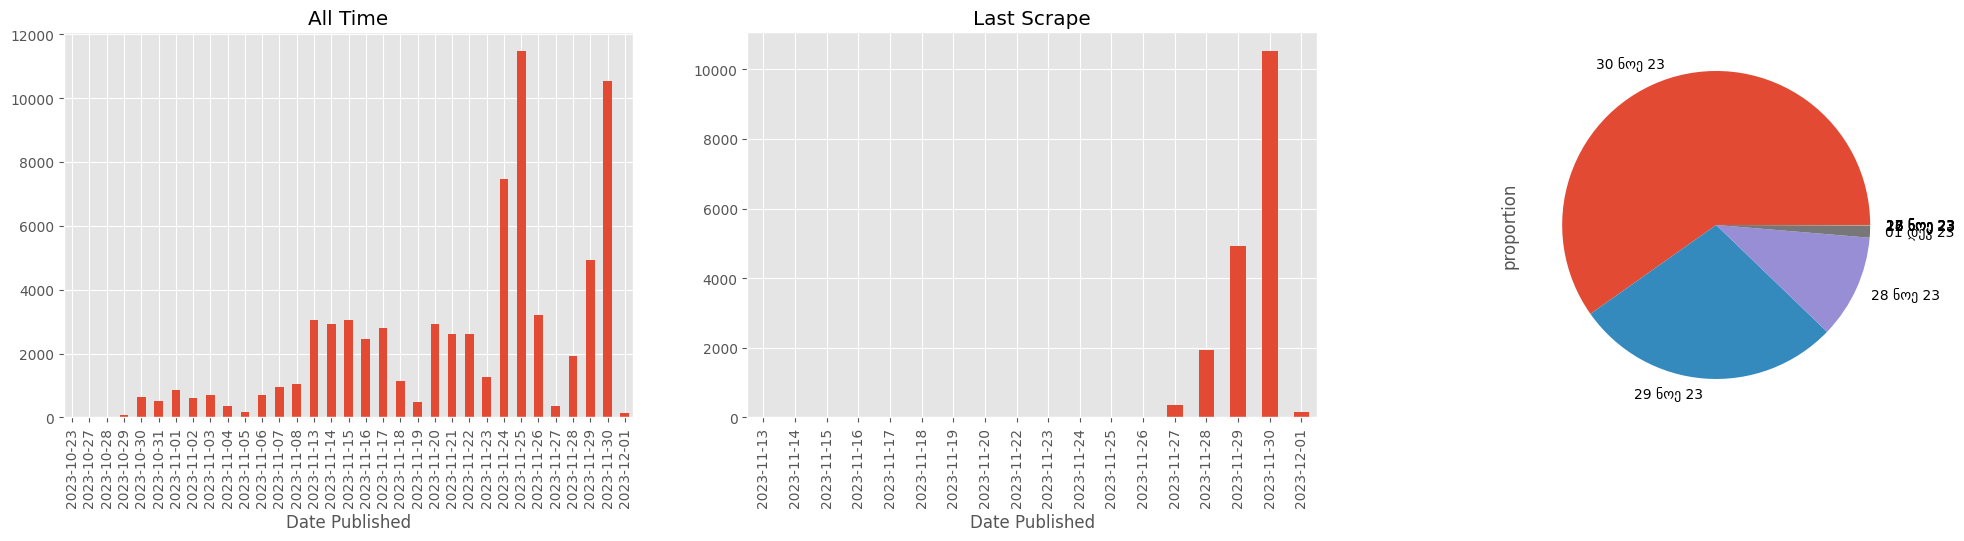

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(25,5))
processed_df.groupby(pd.to_datetime(processed_df['Date Published'],errors='coerce').dt.to_period('D'))['Article ID'].count().plot.bar(ax=ax1,title='All Time')
processed_df.iloc[len(df)-len(daily_df):].groupby(pd.to_datetime(processed_df.iloc[len(df)-len(daily_df):]['Date Published'],errors='coerce').dt.to_period('D'))['Article ID'].count().plot.bar(ax=ax2,title='Last Scrape')
daily_df['Date Published'].apply(lambda x:x.split(', ')[0] if isinstance(x,str) else None).value_counts(normalize=True).plot.pie(ax=ax3)
plt.show()

# Grouped DF

In [16]:
processed_df['Date Published']=pd.to_datetime(df['Date Published'],errors='coerce')

In [17]:
all_time_grouped=processed_df.groupby([processed_df['Date Published'].dt.date,'General Address','Status','Condition']).agg({'Article ID':'count','Price Per SQMT':'median'}).reset_index()

all_time_grouped=all_time_grouped.sort_values('Date Published')

#all_time_grouped.to_csv(os.path.join('dash','all_time_grouped.csv'),index=False)
all_time_grouped.to_csv(os.path.join('data','all_time_grouped.csv'),index=False)

print('Finished all_time_grouped.csv')

Finished all_time_grouped.csv


In [18]:
min_date=pd.to_datetime(all_time_grouped['Date Published']).min()
max_date=pd.to_datetime(all_time_grouped['Date Published']).max()

print(min_date, max_date)

2023-10-23 00:00:00 2023-12-01 00:00:00


# Coordinates DF

In [21]:
coordinates_df=processed_df[['Date Published','Price Per SQMT','Lat','Lon','Street']]
coordinates_df['Size']=coordinates_df.index

coordinates_grouped=coordinates_df.groupby([coordinates_df['Date Published'].dt.to_period('W'),'Lat','Lon','Street']).agg({'Size':'count','Price Per SQMT':'median'}).reset_index()
coordinates_grouped['Size']=coordinates_grouped['Size']/coordinates_grouped['Size'].sum()

coordinates_grouped.to_csv('data/coordinates_grouped.csv',index=False)